In [1]:
import nltk
from collections import Counter
from nltk.corpus import reuters
from nltk import word_tokenize

# Load and tokenize the dataset
nltk.download('reuters')
nltk.download('punkt')

# Load and tokenize the dataset
corpus = reuters.raw().lower()
words = word_tokenize(corpus)

# Build vocabulary
vocab = Counter(words)
vocab = {word: idx for idx, (word, _) in enumerate(vocab.items())}
idx_to_word = {idx: word for word, idx in vocab.items()}
vocab_size = len(vocab)

# Check vocab size
print(f"字典大小: {vocab_size}")


[nltk_data] Downloading package reuters to
[nltk_data]     /home/disk1/xiaoliangyang/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/disk1/xiaoliangyang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


字典大小: 52877


In [2]:
# 生成skip-gram对
def generate_skipgram_pairs(words, vocab, window_size=2):
    pairs = []
    for i, word in enumerate(words):
        if word not in vocab:
            continue
        for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
            if i != j and words[j] in vocab:
                pairs.append((vocab[word], vocab[words[j]]))
    return pairs

skipgram_pairs = generate_skipgram_pairs(words, vocab)


In [3]:
import torch
import torch.nn as nn

# 定义Word2Vec模型

class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_size)
        self.out_embed = nn.Embedding(vocab_size, embed_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, center):
        center_embed = self.in_embed(center)
        scores = torch.matmul(center_embed, self.out_embed.weight.t())
        return self.log_softmax(scores)

    def get_embedding(self):
        return self.in_embed.weight.data.cpu().numpy()

 17%|█▋        | 5/30 [04:06<20:37, 49.50s/it]

Epoch 5, Loss: 0.012595787855487229


 33%|███▎      | 10/30 [07:52<14:53, 44.67s/it]

Epoch 10, Loss: 0.012196570220726835


 50%|█████     | 15/30 [11:49<11:49, 47.28s/it]

Epoch 15, Loss: 0.012109828326129156


 67%|██████▋   | 20/30 [15:44<07:56, 47.69s/it]

Epoch 20, Loss: 0.01205978487055742


 83%|████████▎ | 25/30 [19:42<03:58, 47.61s/it]

Epoch 25, Loss: 0.012020690605085383


100%|██████████| 30/30 [23:39<00:00, 47.32s/it]

Epoch 30, Loss: 0.011985804468925733


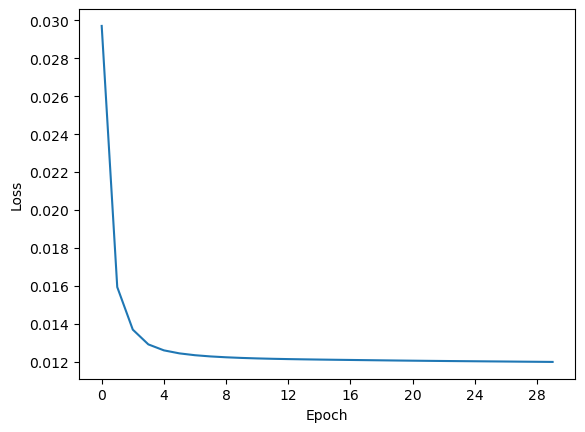

In [12]:
from matplotlib import pyplot as plt, ticker
from torch import optim
from tqdm import tqdm

# 训练Word2Vec模型
def train_word2vec(model, pairs, epochs=5, batch_size=512, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    tot_loss = []
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for i in range(0, len(pairs), batch_size):
            batch_pairs = pairs[i:i+batch_size]
            if not batch_pairs:
                continue

            centers, contexts = zip(*batch_pairs)
            centers = torch.tensor(centers, dtype=torch.long).to(device)
            contexts = torch.tensor(contexts, dtype=torch.long).to(device)

            optimizer.zero_grad()
            scores = model(centers)
            loss = criterion(scores, contexts)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch + 1}, Loss: {total_loss / len(pairs)}')
        tot_loss.append(total_loss / len(pairs))

    return tot_loss

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
embed_size = 100
word2vec_model = Word2Vec(vocab_size, embed_size).to(device)
tot_loss = train_word2vec(word2vec_model, skipgram_pairs, epochs=30)

_, ax = plt.subplots()
ax.plot(range(len(tot_loss)), tot_loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()